In [1]:
MAKE_BOOK_FIGURES=True

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def set_notebook_style():
    plt.style.use('seaborn-v0_8-white')
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings - using default sizes
        'font.family': 'serif',
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        
        # Line and marker settings
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout settings
        'figure.constrained_layout.use': True,
        
        # Remove only top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional settings
        'figure.autolayout': True,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)

def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
else:
    set_notebook_style()

make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

In [ ]:
!pip install gpytorch

# Expected Improvement - With Observation Noise

We develop intuition about the expected improvement in the presence of observation noise.

## Optimizing Noisy Functions

The optimization of noisy functions is relevant when you are dealing with experimentally measured objectives.
In such a scenario, you do not observe $f(\mathbf{x})$, but a noisy version.
Here is a prototypical scenario of an experimentally measured objective.
Let $\xi$ be all the variables that affect the objective and assume that they are distributed in a way not necessarily known to you:

$$
\xi \sim p(\xi).
$$

The you setup your experiment using a design $\mathbf{x}$ and you measure:

$$
y = g(\mathbf{x}, \xi).
$$

Let's assume now that you would like to maximize the expectation of this function, i.e., you want to maximize

$$
f(\mathbf{x}) = \mathbb{E}_\xi[g(\mathbf{x},\xi)].
$$

The expectation here is over the experimental noise.

A naïve way of solving this problem is to approximate the expectation using sample averaging.
At each $\mathbf{x}$, you do many experiments instead of just one.
If your experiments are not very expensive, you may do that.
Then, any of the algorithms above would work in your problem.

So, what do you do when you cannot eliminate the noise?
Well, this is an open problem.
But here is a quick and dirty solution that may work in many cases.
First, use GPR to approximate $f(\mathbf{x})$ using noisy measurements:

$$
y_i = g(\mathbf{x},\xi_i),
$$

for $i=1,\dots,n$. 
You do not necessarily have to observe the $\xi$'s.
You can assume that they are hidden. If you do observe them, you can exploit this fact.
But, for now, let's assume that you don't observe them.
If you don't observe them, you need to model their effect.
The more straightforward thing to do is to assume that their effect is additive, zero mean, and Gaussian.
That is, we assume that:

$$
y_i = f(\mathbf{x}_i) + \epsilon_i,
$$

where $\epsilon_i \sim \mathcal{N}(0,\sigma^2)$, where $\sigma^2$ is to be determined.
When we do this, we can use GPR to find our posterior state of knowledge about $f(\cdot)$ and any hyperparameters).
We will be just using a MAP estimate for the hyperparameters.

The posterior GP conditioned on the observed data is given by the usual formulas:

$$
f(\cdot)|\mathcal{D}_n \sim \operatorname{GP}(m_n(\cdot), k_n(\cdot,\cdot)).
$$

Since we will be doing sequential experiment design, we will also need the point-predictive distribution for the measurement $y$ at a hypothetical $\mathbf{x}$.
It is:

$$
p(y|\mathbf{x},\mathcal{D}_n) = \mathcal{N}(y|m_n(\mathbf{x}), \sigma_n^2(\mathbf{x}) + \sigma^2),
$$

where $\sigma_n^2(\mathbf{x}) = k_n(\mathbf{x},\mathbf{x})$, i.e., the posterior variance for $f(\mathbf{x})$.
We now have all the ingredients to modify the information acquisition functions above for the noisy cases.

/Users/ibilion/.pyenv/versions/3.11.6/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/ibilion/.pyenv/versions/3.11.6/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


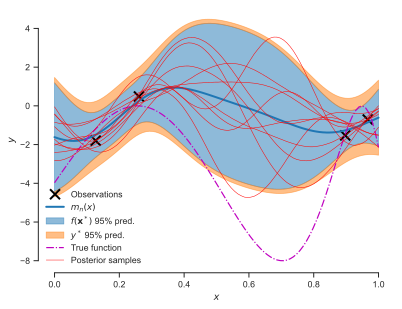

In [2]:
np.random.seed(123456)


def f(x):
    """A function to optimize."""
    return -4 * (1. - np.sin(6 * x + 8 * np.exp(6 * x - 7.))) 

# noisy version of the above function
sigma_noise = 0.4
g = lambda x: (
    f(x)
    + sigma_noise * np.random.randn(x.shape[0])
)

# Generate some data:
n_init = 4
X = np.random.rand(n_init)
Y = g(X)

# Do GPR
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y)

model.covar_module.base_kernel.lengthscale = 0.15
model.covar_module.outputscale = 4.0
model.likelihood.noise = 0.4
model.eval()

x = torch.linspace(0, 1, 100)
plot_1d_regression(
    x,
    model,
    f_true=f
);

## Maximum upper interval with noise

The maximum upper interval remains the same:

$$
a_n(\mathbf{x}) = \mu_n(\mathbf{x}) + \psi \sigma_n(\mathbf{x}),
$$

for some $\psi \ge 0$.
Ensure you don't add the $\sigma^2$ term in the variance.
Here it is:

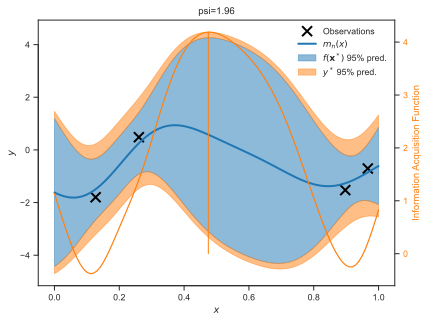

In [3]:
plot_iaf(
    x,
    model,
    mui,
    alpha_params=dict(psi=1.96)
)

## Probability of improvement with noise

We need to make some modifications to the probability of improvement.
First, because they are noisy, we cannot use the $y_n^*$ as the maximum of the $y_i$'s.
Instead, we are looking at the predictive mean of the GP, $m_n(\mathbf{x}_i)$, at the corresponding inputs, $\mathbf{x}_i$, and we find their maximum.
So, define:

$$
m_n^* = \max_{1\le i\le n}m_n(\mathbf{x}_i).
$$

Instead of finding the maximum of the noisy observations, we are smoothing with the predictive mean of the GP and find the maximum of the smoothed versions.
The rest is similar.
The acquisition function is defined by:

$$
a_n(\mathbf{x}) = \mathbb{P}[f(\mathbf{x}) > m_n^* + \psi | \mathbf{x}, \mathcal{D}_n].
$$

We read that "$a_n(\mathbf{x})$" is the probability that we observe at $x$ a $y$ that is greater than the currently observed maximum $y_n^*$ by at least $\psi>0$.
The good thing is that it is possible to get an analytical answer because our point predictive distribution is Gaussian.
In particular, we get:

$$
\begin{align}
a_n(\mathbf{x}) &=& \mathbb{P}[f(\mathbf{x}) > m_n^* + \psi | \mathbf{x}, \mathcal{D}_n]\\
&=& \mathbb{P}\left[\frac{f(\mathbf{x}) - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} > \frac{m_n^* + \psi - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} \Big| \mathbf{x}, \mathcal{D}_n\right]\\
&=& \dots\\
&=& \Phi\left(\frac{\mu_n(\mathbf{x}) - m_n^* - \psi}{\sigma_n(\mathbf{x})} \right).
\end{align}
$$

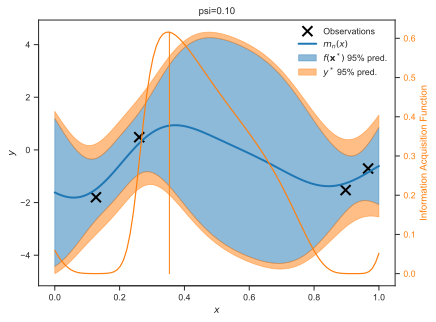

In [4]:
plot_iaf(
    x,
    model,
    poi,
    alpha_params=dict(psi=0.1)
)

## Expected improvment with noise

The arguments here are as in the previous section about the probability of improvement.
Consider a hypothetical experiment at $\mathbf{x}$ and assume that you observed $y$.
How much improvement is that compared to your currently best observed point $m_n^*$.
It is:

$$
I_n(\mathbf{x}, f(\mathbf{x})) =
\begin{cases}
0,&\;\text{if}\;f(\mathbf{x}) \le m_n^*,\\
f(\mathbf{x}) - m_n^*,&\;\text{otherwise},
\end{cases}
$$

and this conditional of $y$, i.e., $f(\mathbf{x})$ is a random variable conditioned on $y$.
Taking the expectation over $y$ would give you:

$$
\operatorname{EI}_n(\mathbf{x}) = \left(m_n(\mathbf{x}) - m_n^*\right)\Phi\left(\frac{m_n(\mathbf{x}) - m_n^*}{\sigma_n(\mathbf{x})}\right)
+ \sigma_n(\mathbf{x})\phi\left(\frac{m_n(\mathbf{x}) - m_n^*}{\sigma_n(\mathbf{x})}\right).
$$

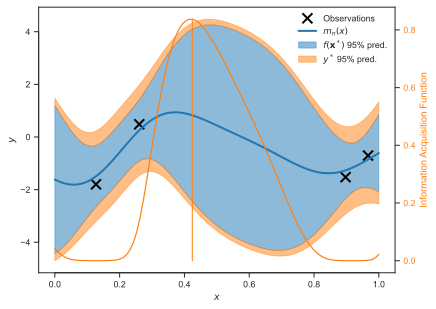

In [5]:
plot_iaf(
    x,
    model,
    ei
)

And here optimization with noise:

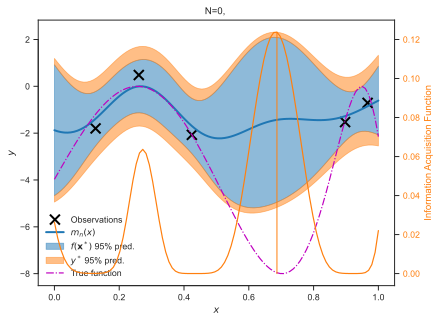

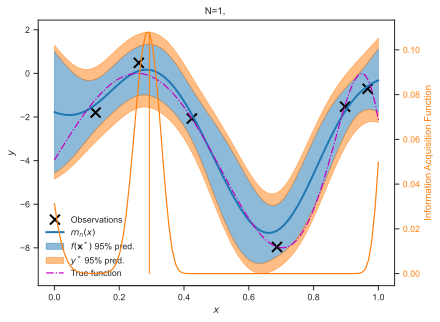

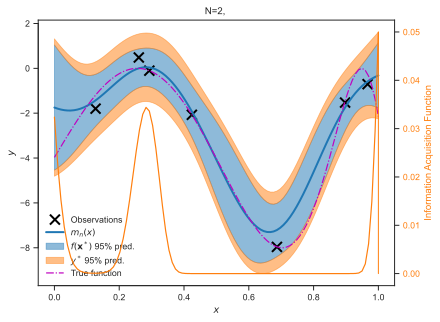

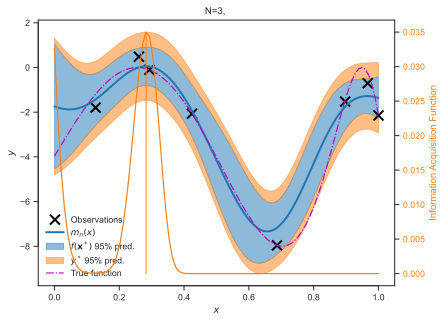

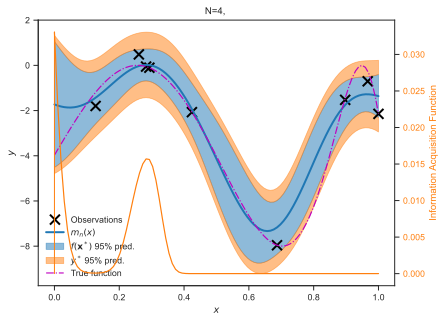

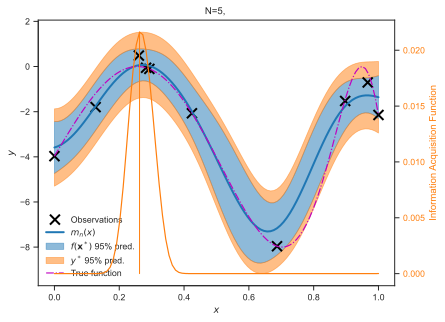

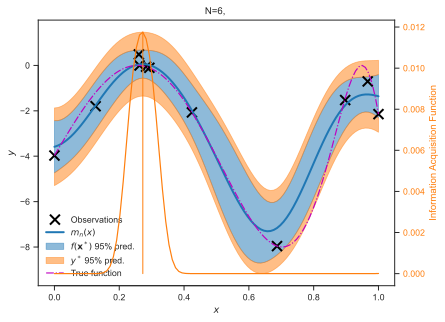

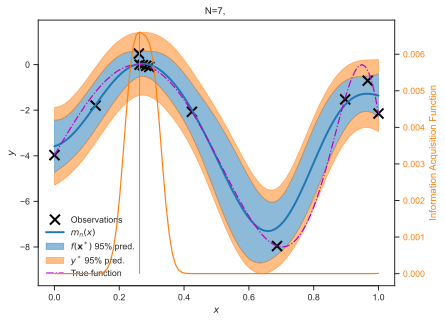

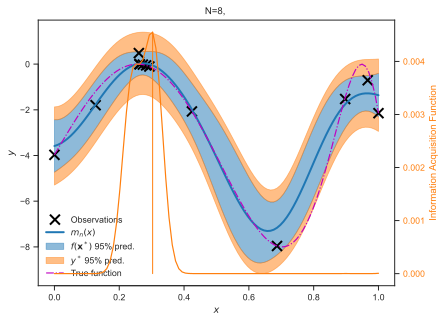

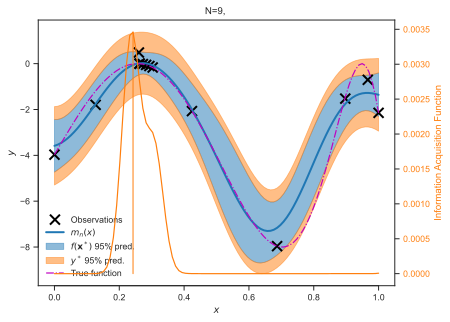

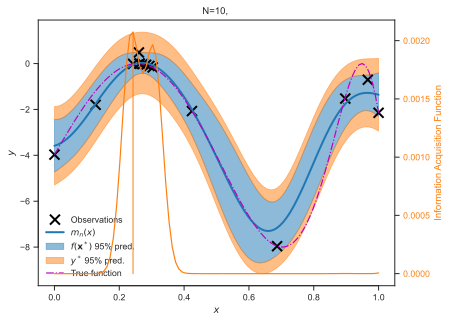

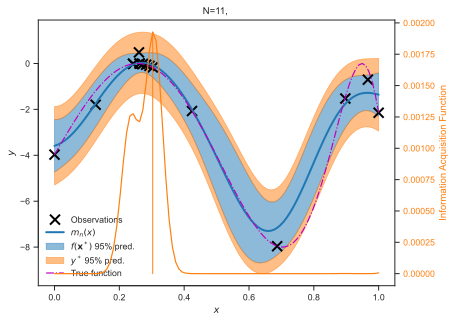

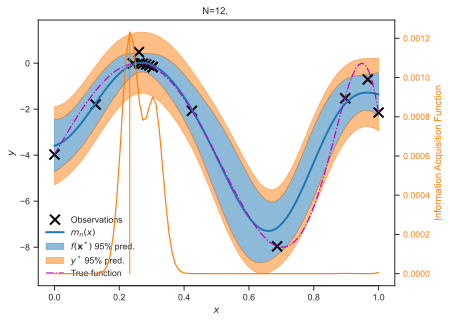

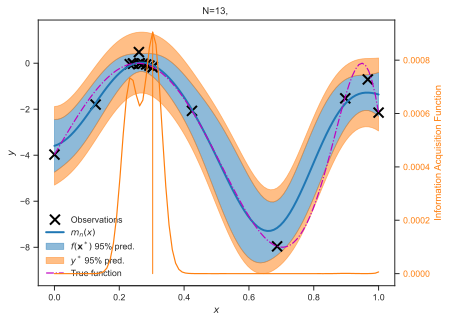

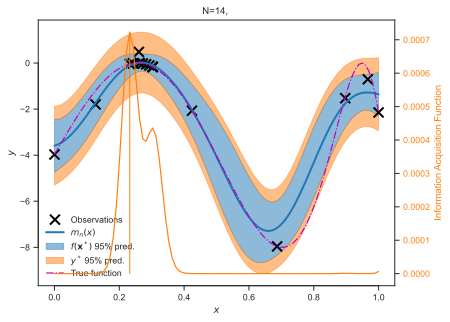

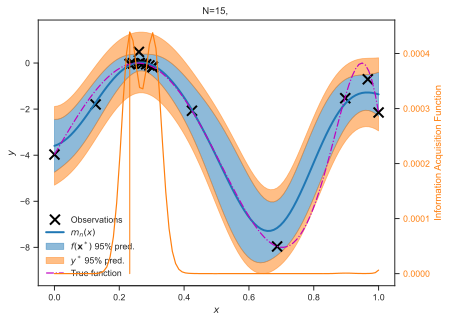

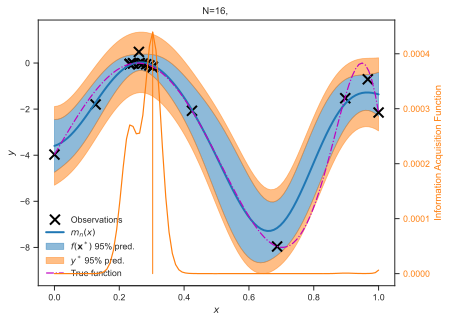

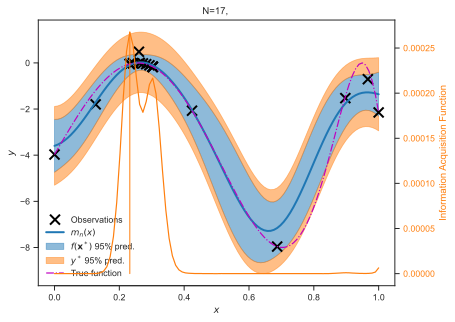

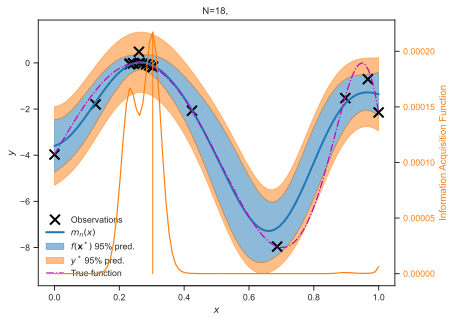

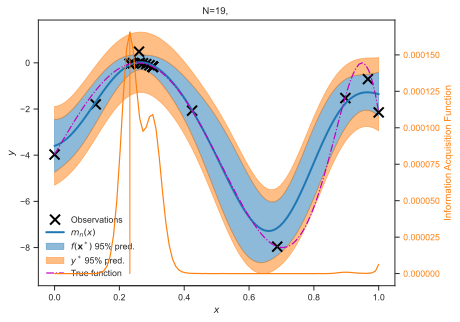

In [6]:
# Run the algorithm
af_all = maximize(
    f,
    model,
    x,
    ei,
    max_it=20,
    plot=1
)

## Questions

+ Rerun the algorithm above starting with 3 observations. Does the algorithm find the same local maximum?
If not, why?
+ Experiment with smaller noise. 
+ Experiment with larger noise.